In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

---------------------

# Retrieving and Preprocess Data

Image size:  100


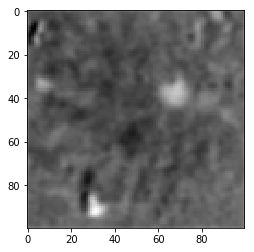

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'lisa_08' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 100
MAX_EPOCHS = 200
l1_coeff = 0.1
thr = 0.3 #threshold for one hot pixel* sim score
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()   
    break
    

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


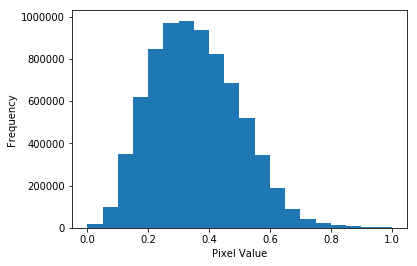

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#reshape
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[100 1 1 2]


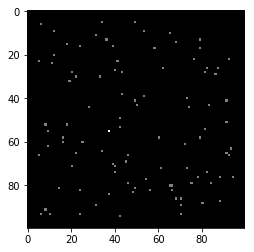

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size):
    
    #activity_regularizer=l1(0.1)
    #conv block1
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord=tf.pad(inps, paddings, "REFLECT")
    coord1 =CoordConv(x_dim = 102, y_dim = 102, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='valid')(coord)
    
    act1=tf.keras.layers.ReLU()(coord1)
    
    #paddings1 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    #coord2=tf.pad(act1, paddings1, "REFLECT")
    pool1=MaxPooling2D((2, 2), padding='same')(act1)
    #obj=MaxBlurPool()
    #pool1=obj(act1)
    
    #conv block2
    
    #act1=tf.keras.layers.ReLU()(coord1)
    paddings2 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord3=tf.pad(pool1, paddings2, "REFLECT")

    conv1=Conv2D(64, kernel_size = 3, padding='valid',activation = 'relu')(coord3)
    
    #paddings3 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    #coord4=tf.pad(conv1, paddings3, "REFLECT")
    pool2=MaxPooling2D((2, 2),padding='same')(conv1)
    
    paddings4 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord5=tf.pad(pool2, paddings4, "REFLECT")
    #x = Conv2D(128, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(0.1))(pool2)
    x = Conv2D(128, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord5)
    x = UpSampling2D(size=(2, 2),interpolation='bilinear')(x) 
    
    paddings5 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings5, "REFLECT")
    x = Conv2D(64, 3, padding = 'valid', activation = 'relu')(x)
    # x = Conv2D(64, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(0.1))(x)
    x = UpSampling2D(size=(2,2),interpolation='bilinear')(x)
    paddings6 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings6, "REFLECT")
    x = Conv2D(16, 3, padding = 'valid', activation = 'relu')(x)
    paddings7 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings7, "REFLECT")
    output = Conv2D(1, 3, padding = 'valid', activation = 'sigmoid', activity_regularizer=l1(0.1))(x)
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return tf.cast(duplicate_imgs, dtype = tf.float32)

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
        #clip values so that the values doesnt runs out of the normalized pixel space 
        y = tf.clip_by_value(y, clip_value_min=0.0, clip_value_max=1.0) 
        return y

In [8]:
# def encoder02(inps, img_size):
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same',
#                        activity_regularizer=l1(l1_coeff))(inps)
#     leaky01 =tf.keras.layers.ReLU()(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", 
#                     activation = 'relu',activity_regularizer=l1(l1_coeff))(leaky01 )
#     leaky02 = tf.keras.layers.ReLU()(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', 
#                     padding='same',activity_regularizer=l1(l1_coeff))(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
bxent = tf.keras.losses.BinaryCrossentropy()
msle = tf.keras.losses.MeanSquaredLogarithmicError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = False, one_hot_thr = False):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if neuron_multi==False:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = msle(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = msle(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        elif neuron_multi==True:
            #with thresholding 
            if one_hot_thr==True:
                #multiply similarity scores with one hot images
                #(batch_size, img_size, img_size, 1)
                similarity_multi_threshold = similarity_multi(one_hot_imgs, similarity_score, thr)
                similarity_multi_threshold_dummy = similarity_multi(dummy_one_hot, similarity_score, thr)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = msle(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = msle(encoder_output, similarity_multi_threshold_dummy)
            #without thresholding
            elif one_hot_thr==False: 
                similarity_multi_reduced_neurons = similarity_multi(one_hot_imgs, similarity_score)
                similarity_multi_reduced_dummy = similarity_multi(dummy_one_hot, similarity_score)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = msle(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = msle(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #total global loss => global_loss + regularizer loss
        total_loss = global_loss + regularizer_loss
        #append loss 
        loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables
    grad_encoder = tape.gradient(encoded_one_loss, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(global_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     print(d)
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

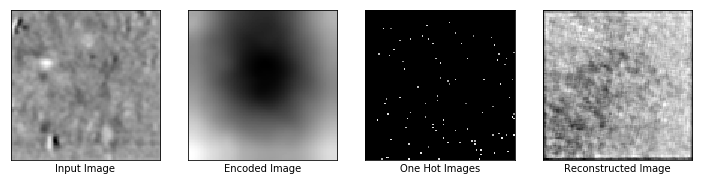

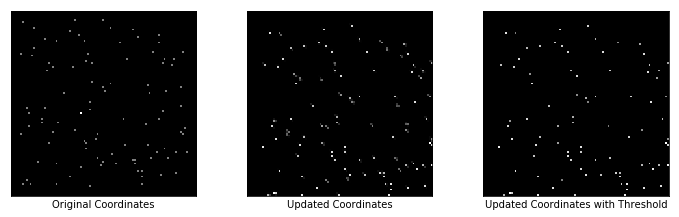

Epochs: 1, Reconstruction Loss: 0.02723981998860836
Regularizer Loss: 862.3699340820312, Total Loss: 862.3971557617188
Encoder Loss: 0.1933870166540146
Max Similarity scores: 0.592686653137207
Updated Coordinates: [[[0.96678084 0.5798021 ]]]
Gradient global min:-8.97175632417202e-05, max:2.1776830180897377e-05
Gradient encoder min:-0.004777306690812111, max:0.004539241548627615
Gradient learnable coords min:-1.3715045952267246e-06, max:2.0629691732665378e-07



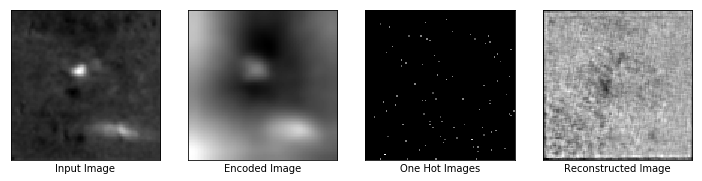

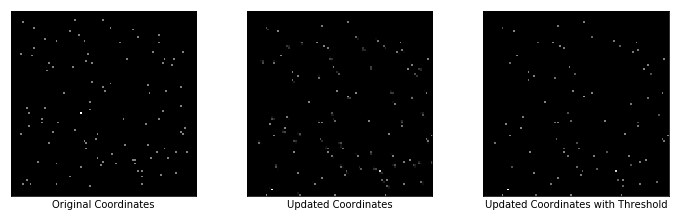

Epochs: 1, Reconstruction Loss: 0.02618103288114071
Regularizer Loss: 738.5604248046875, Total Loss: 738.5866088867188
Encoder Loss: 0.1737489253282547
Max Similarity scores: 0.5368497371673584
Updated Coordinates: [[[0.9471858 0.5591699]]]
Gradient global min:-0.0005674194544553757, max:0.0010735527612268925
Gradient encoder min:-0.0034114408772438765, max:0.002578564453870058
Gradient learnable coords min:0.0, max:4.845622243010439e-06



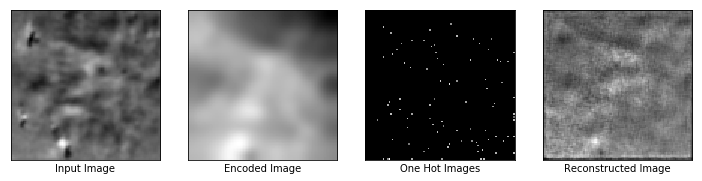

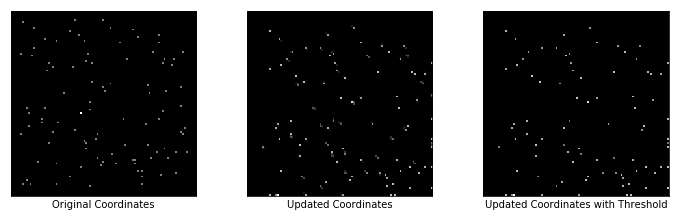

Epochs: 1, Reconstruction Loss: 0.005489372182637453
Regularizer Loss: 849.582275390625, Total Loss: 849.5877685546875
Encoder Loss: 0.18302015960216522
Max Similarity scores: 0.5613687038421631
Updated Coordinates: [[[1.         0.58431363]]]
Gradient global min:-0.000174455635715276, max:8.893483027350157e-05
Gradient encoder min:-0.00836394913494587, max:0.008113374933600426
Gradient learnable coords min:-5.67906624837633e-07, max:3.804678385677107e-07



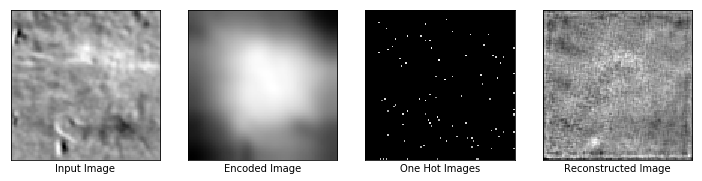

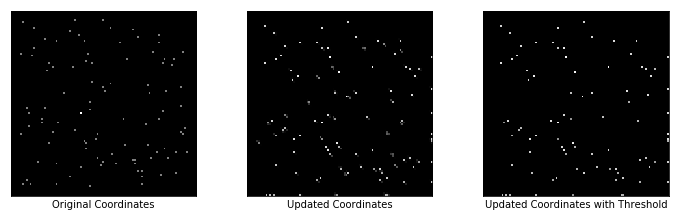

Epochs: 1, Reconstruction Loss: 0.103206567466259
Regularizer Loss: 869.7615966796875, Total Loss: 869.8648071289062
Encoder Loss: 0.14941692352294922
Max Similarity scores: 0.5394336581230164
Updated Coordinates: [[[1.        0.5583877]]]
Gradient global min:-0.0009842382278293371, max:0.0009547514491714537
Gradient encoder min:-0.014218633063137531, max:0.016763940453529358
Gradient learnable coords min:-1.0876173291762825e-05, max:2.9466134492395213e-06



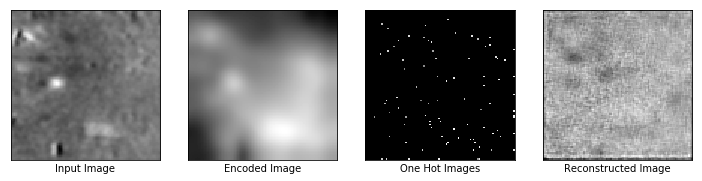

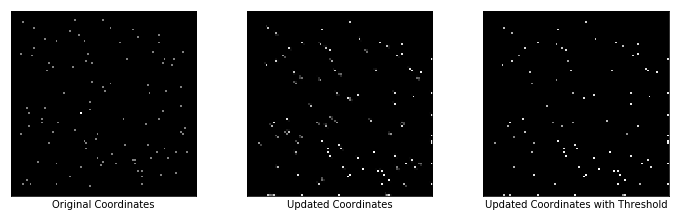

Epochs: 1, Reconstruction Loss: 0.025052767246961594
Regularizer Loss: 937.023681640625, Total Loss: 937.0487060546875
Encoder Loss: 0.19103947281837463
Max Similarity scores: 0.5989441275596619
Updated Coordinates: [[[1.         0.56883746]]]
Gradient global min:-0.0015861383872106671, max:0.0010229961480945349
Gradient encoder min:-0.015181930735707283, max:0.017259422689676285
Gradient learnable coords min:-5.85415091336472e-06, max:2.1593777432826755e-07



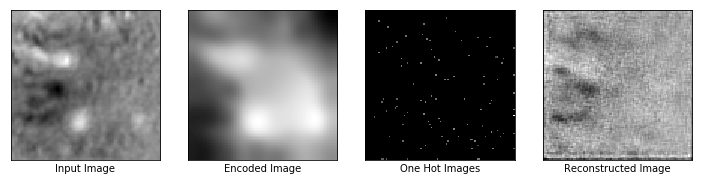

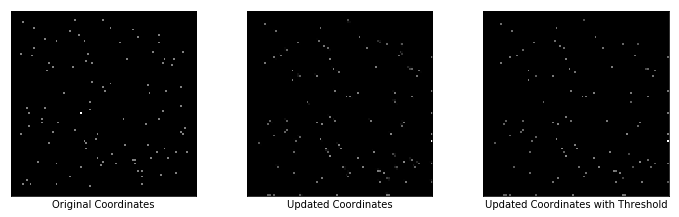

Epochs: 1, Reconstruction Loss: 0.016486912965774536
Regularizer Loss: 890.545654296875, Total Loss: 890.5621337890625
Encoder Loss: 0.15037032961845398
Max Similarity scores: 0.6308324933052063
Updated Coordinates: [[[1.         0.55433226]]]
Gradient global min:-0.00025623507099226117, max:0.0002305049856659025
Gradient encoder min:-0.028492625802755356, max:0.022901808843016624
Gradient learnable coords min:-1.93545270121831e-06, max:1.4474431964117684e-06



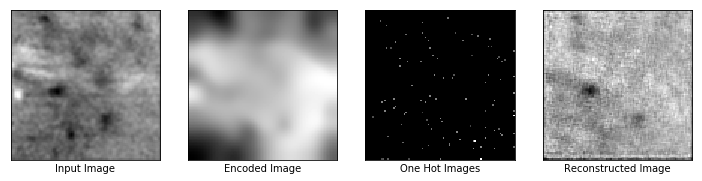

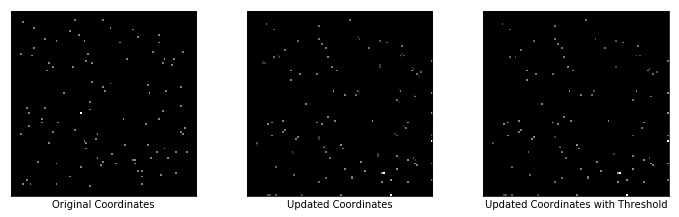

Epochs: 1, Reconstruction Loss: 0.04838917776942253
Regularizer Loss: 1322.9779052734375, Total Loss: 1323.0262451171875
Encoder Loss: 0.2487606406211853
Max Similarity scores: 0.7310782074928284
Updated Coordinates: [[[1.        0.5538711]]]
Gradient global min:-0.001457095961086452, max:0.0012743966653943062
Gradient encoder min:-0.035329513251781464, max:0.04984838515520096
Gradient learnable coords min:-1.8466340407030657e-05, max:2.264164550069836e-06



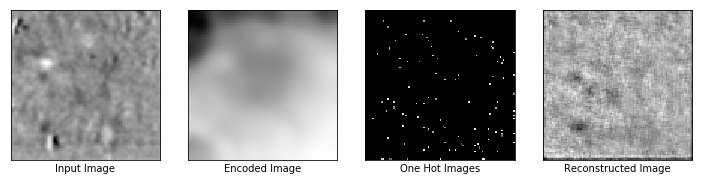

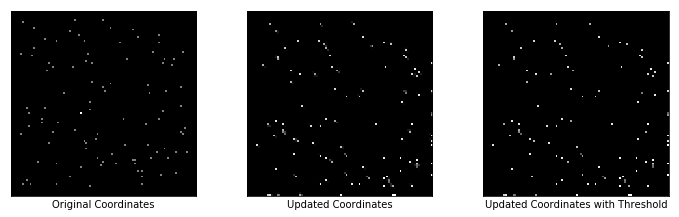

Epochs: 2, Reconstruction Loss: 0.013047141954302788
Regularizer Loss: 1362.1414794921875, Total Loss: 1362.154541015625
Encoder Loss: 0.22011587023735046
Max Similarity scores: 0.8817946910858154
Updated Coordinates: [[[1.       0.560608]]]
Gradient global min:-0.0005734270089305937, max:0.0005000160890631378
Gradient encoder min:-0.05530305951833725, max:0.05784628540277481
Gradient learnable coords min:-1.19975056804833e-05, max:1.037610309140291e-05



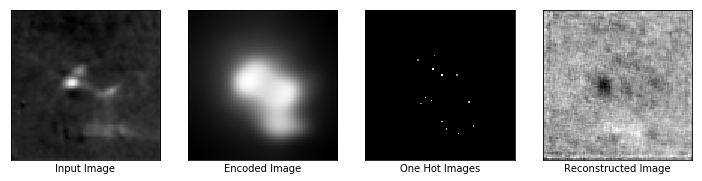

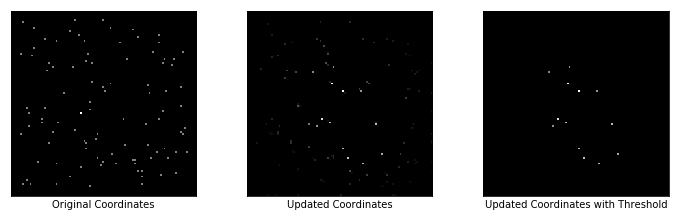

Epochs: 2, Reconstruction Loss: 0.015183912590146065
Regularizer Loss: 948.4281616210938, Total Loss: 948.443359375
Encoder Loss: 0.037568580359220505
Max Similarity scores: 0.693121612071991
Updated Coordinates: [[[1.        0.5499303]]]
Gradient global min:-0.00045654020505025983, max:0.0002725736703723669
Gradient encoder min:-0.018813423812389374, max:0.01201462559401989
Gradient learnable coords min:-2.2469745090347715e-05, max:2.0313180357334204e-05



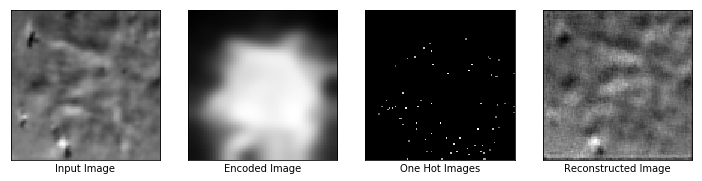

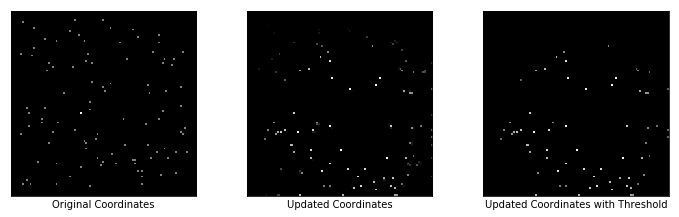

Epochs: 2, Reconstruction Loss: 0.0035630599595606327
Regularizer Loss: 1511.2537841796875, Total Loss: 1511.25732421875
Encoder Loss: 0.16173464059829712
Max Similarity scores: 0.869513213634491
Updated Coordinates: [[[1.        0.5664901]]]
Gradient global min:-0.00032898777863010764, max:0.000329566013533622
Gradient encoder min:-0.10174933075904846, max:0.0958004742860794
Gradient learnable coords min:-6.749475687684026e-06, max:5.726732979383087e-06



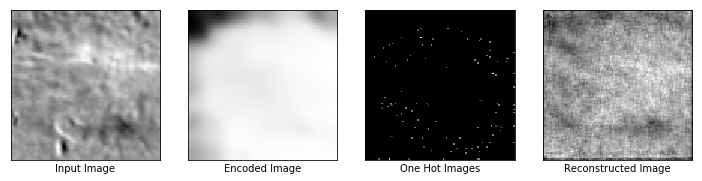

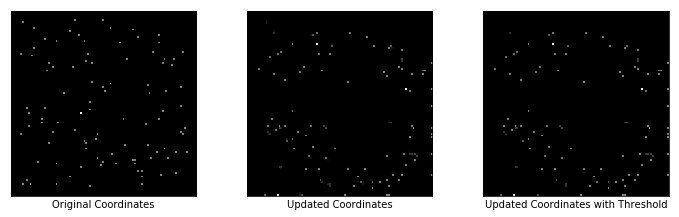

Epochs: 2, Reconstruction Loss: 0.014218665659427643
Regularizer Loss: 2130.76220703125, Total Loss: 2130.7763671875
Encoder Loss: 0.3785676956176758
Max Similarity scores: 0.9698771238327026
Updated Coordinates: [[[1.        0.5159407]]]
Gradient global min:-0.00045125046744942665, max:0.00041823365609161556
Gradient encoder min:-0.05499640479683876, max:0.0833582654595375
Gradient learnable coords min:-1.1936394912481774e-05, max:1.9462013369775377e-06



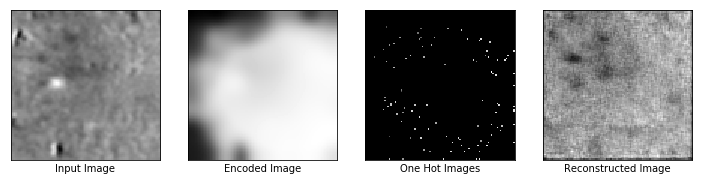

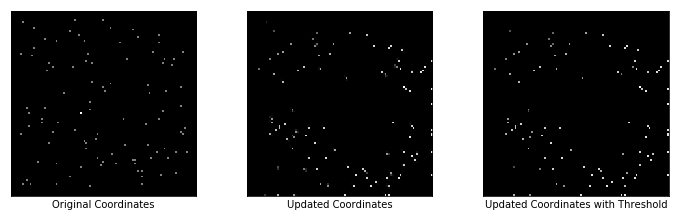

Epochs: 2, Reconstruction Loss: 0.005287581589072943
Regularizer Loss: 1839.381591796875, Total Loss: 1839.3868408203125
Encoder Loss: 0.2734968066215515
Max Similarity scores: 0.9643464684486389
Updated Coordinates: [[[1.       0.503941]]]
Gradient global min:-0.00020287699589971453, max:0.00017802849470172077
Gradient encoder min:-0.06785415858030319, max:0.10259170085191727
Gradient learnable coords min:-2.0952672912244452e-06, max:1.8241587440570584e-06



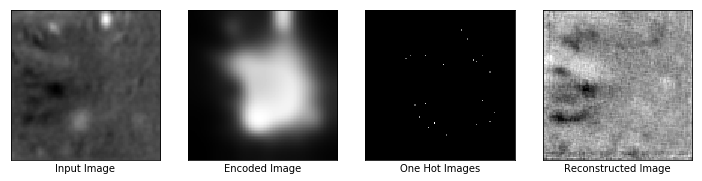

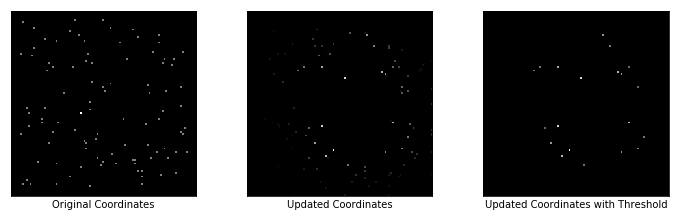

Epochs: 2, Reconstruction Loss: 0.005633337888866663
Regularizer Loss: 1559.0302734375, Total Loss: 1559.035888671875
Encoder Loss: 0.16767290234565735
Max Similarity scores: 0.8549299240112305
Updated Coordinates: [[[1.        0.5013216]]]
Gradient global min:-0.0011974531225860119, max:0.002177164424210787
Gradient encoder min:-0.06350937485694885, max:0.08136077970266342
Gradient learnable coords min:-2.5479869236733066e-06, max:4.766608981299214e-06



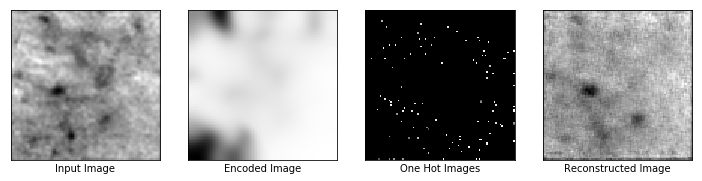

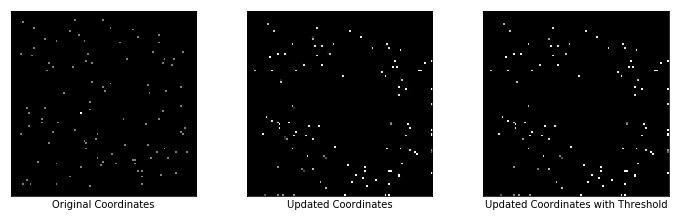

Epochs: 2, Reconstruction Loss: 0.00912642665207386
Regularizer Loss: 2172.3642578125, Total Loss: 2172.373291015625
Encoder Loss: 0.36808738112449646
Max Similarity scores: 0.9819759726524353
Updated Coordinates: [[[1.         0.50868535]]]
Gradient global min:-0.0011282855411991477, max:0.0013667296152561903
Gradient encoder min:-0.06641630828380585, max:0.09327303618192673
Gradient learnable coords min:-2.862186420315993e-06, max:5.842004611622542e-06



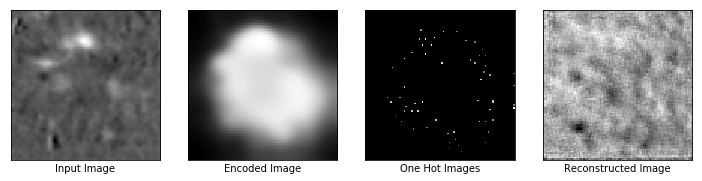

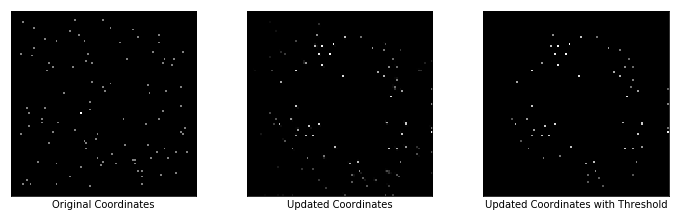

Epochs: 3, Reconstruction Loss: 0.005056458059698343
Regularizer Loss: 1703.9227294921875, Total Loss: 1703.927734375
Encoder Loss: 0.20179393887519836
Max Similarity scores: 0.9284816384315491
Updated Coordinates: [[[1.         0.50434387]]]
Gradient global min:-0.00013801243039779365, max:0.00015181682829279453
Gradient encoder min:-0.06084629148244858, max:0.08005981892347336
Gradient learnable coords min:-4.526952125161188e-06, max:4.095313670404721e-06


In [ ]:
# batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates', 'Updated Coordinates with Threshold']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
#one epochs => loop through all sessions
while epochs <= MAX_EPOCHS:
    #loops through all the sessions
    for session in sorted(os.listdir(ds_dir)):
        merge_sess = os.path.join(ds_dir+session)
        merge_sess = np.load(merge_sess)
        #resize the images
        re_list = utils.resize(merge_sess, NEW_SIZE)
        #add channel 
        re_list = np.expand_dims(re_list, axis = -1)
        re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
        batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
        #initialize list to store data for sessions in last epochs
        one_hot_imgs_last_sess = []
        encoder_output_last_sess = []
        similarity_score_last_sess = []
        reconstruction_last_sess = []
        for batched_imgs in batch_imgs:
            loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                                  IMG_SIZE, BATCH_SIZE,
                                                                                                                  neuron_multi = True,
                                                                                                                 one_hot_thr = True)
            #append all frames for final epochs per session!
            if epochs==MAX_EPOCHS:
                one_hot_imgs_last_sess.append(one_hot_imgs)
                encoder_output_last_sess.append(encoder_output)
                similarity_score_last_sess.append(similarity_score)
                reconstruction_last_sess.append(reconstruction)
        #append all sessions for final epochs! 
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs_last_sess)
            encoder_output_last_list.append(encoder_output_last_sess)
            similarity_score_last_list.append(similarity_score_last_sess)
            reconstruction_last_list.append(reconstruction_last_sess)
        #note for loss indices
        #loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
        rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand], reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(one_hot_imgs, similarity_score)[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand]]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02), figsize = (10, 10))
        #print for each session in the epochs 
        print("Epochs: {}, Reconstruction Loss: {}".format(epochs, loss[0].numpy()))
        print("Regularizer Loss: {}, Total Loss: {}".format(loss[2].numpy(), loss[-1].numpy()))
        print("Encoder Loss: {}".format(loss[1].numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
        print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
        print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
        #append to list 
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
    
    #loss is append for each epochs
    loss_list_global.append(loss[0])
    loss_list_encoded_one_hot.append(loss[1])
    regulariser_loss_list.append(loss[-1])
    #increment epochs
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
#save info for every frames in last epochs
save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

for names, items in zip(save_names_last, save_list_last):
    aggregate_tensor = utils.concat_batch(items)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [16]:
#save one hot imgs for last epochs 
tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [19]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [20]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

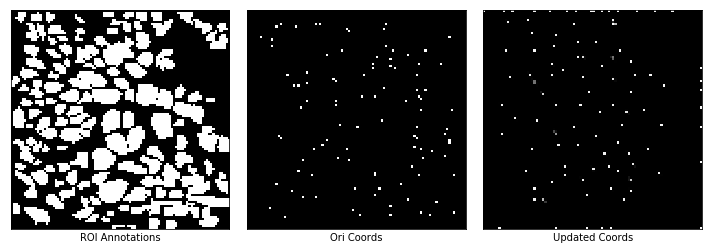

In [21]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.01
Counts:  108


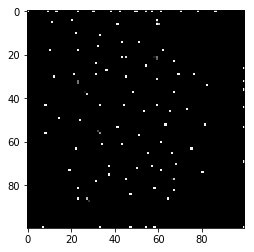

In [22]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

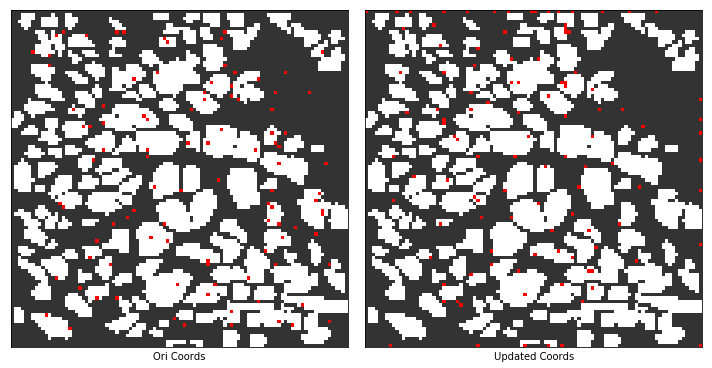

In [23]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [24]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0038
True Negatives:  0.007
False Positive Ratio:  0.4148
False Negatives Ratio:  0.5744
F1 score:  0.017699115044247787


---

# Similarity Scores with Threshold

In [25]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

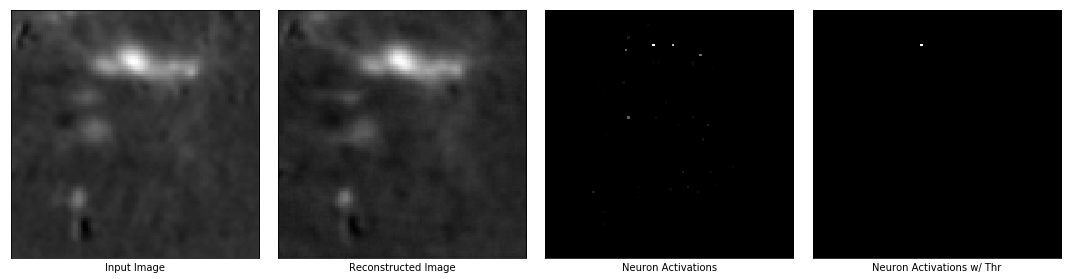

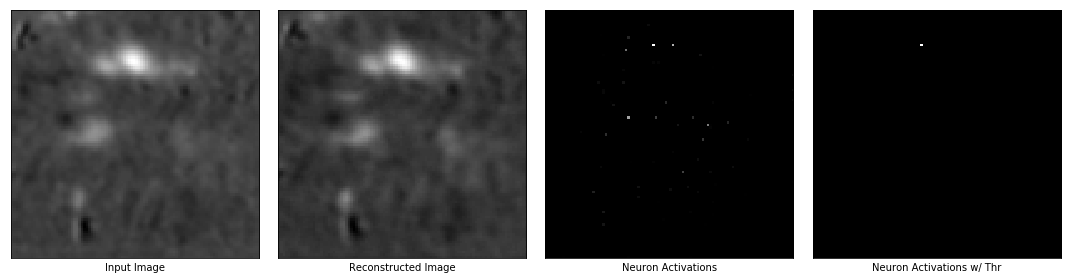

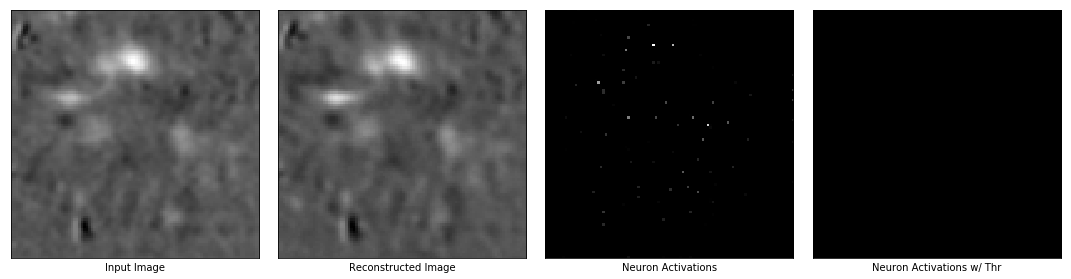

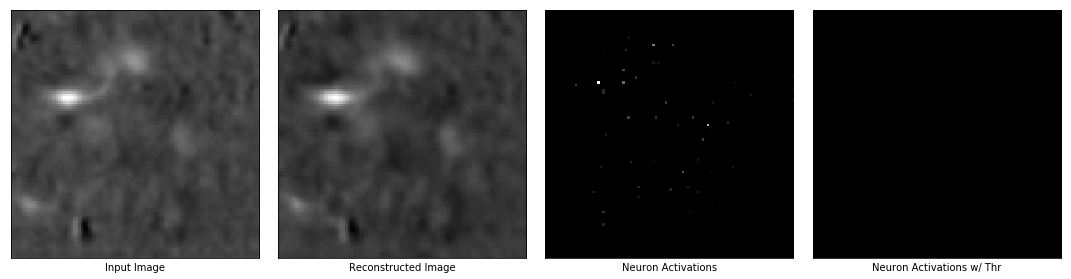

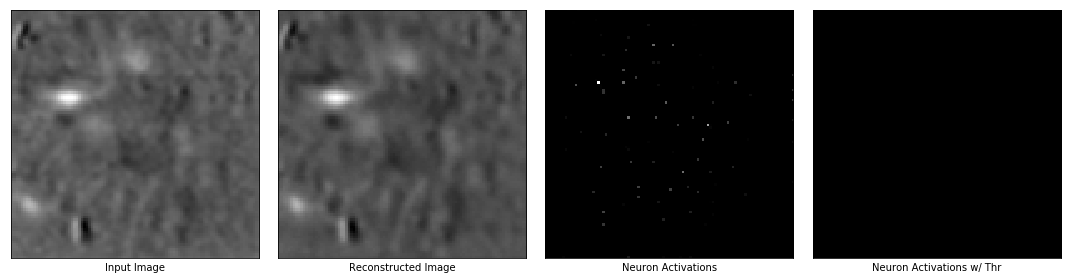

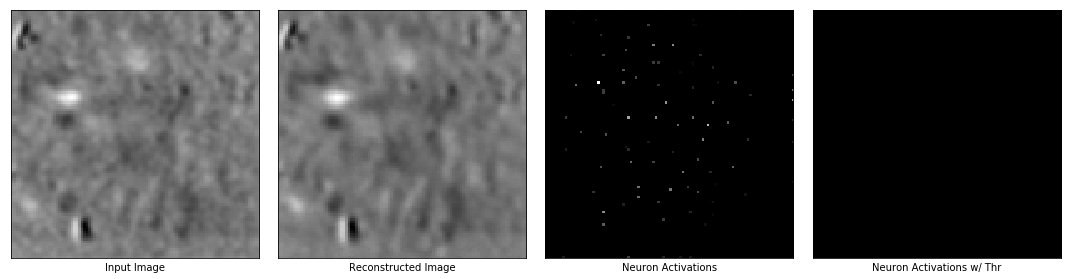

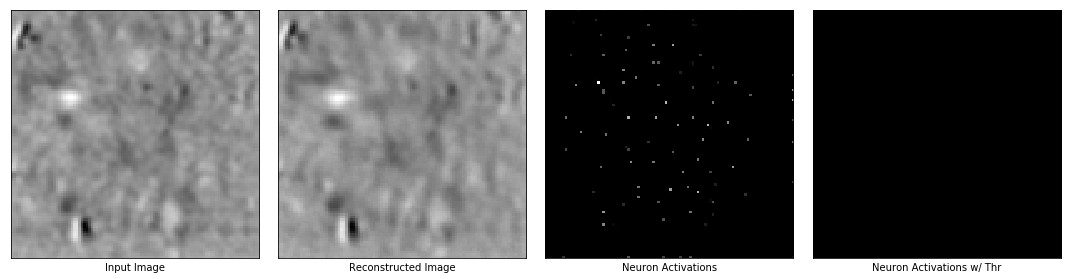

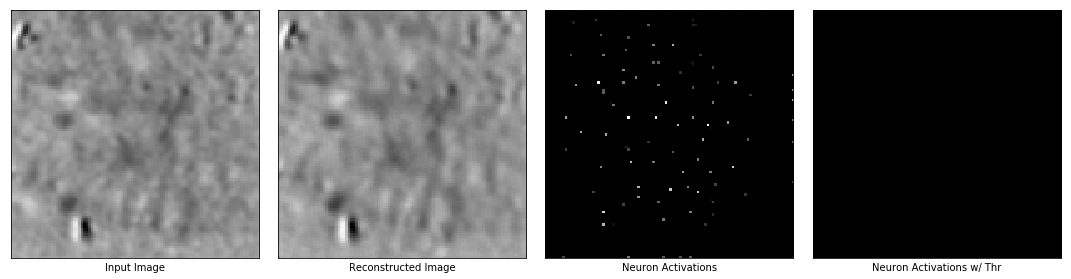

In [26]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

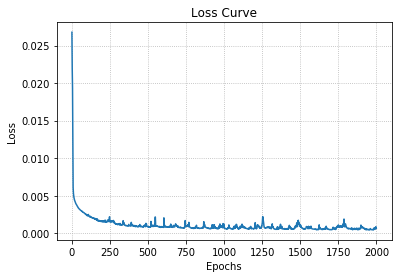

In [27]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [28]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [29]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_6
coord_conv_7
activation_2
up_sampling2d_7
conv2d_32
activation_3
conv2d_33


In [30]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


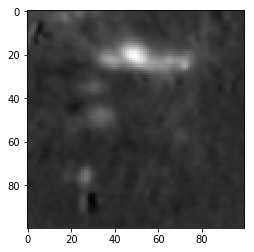

In [31]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


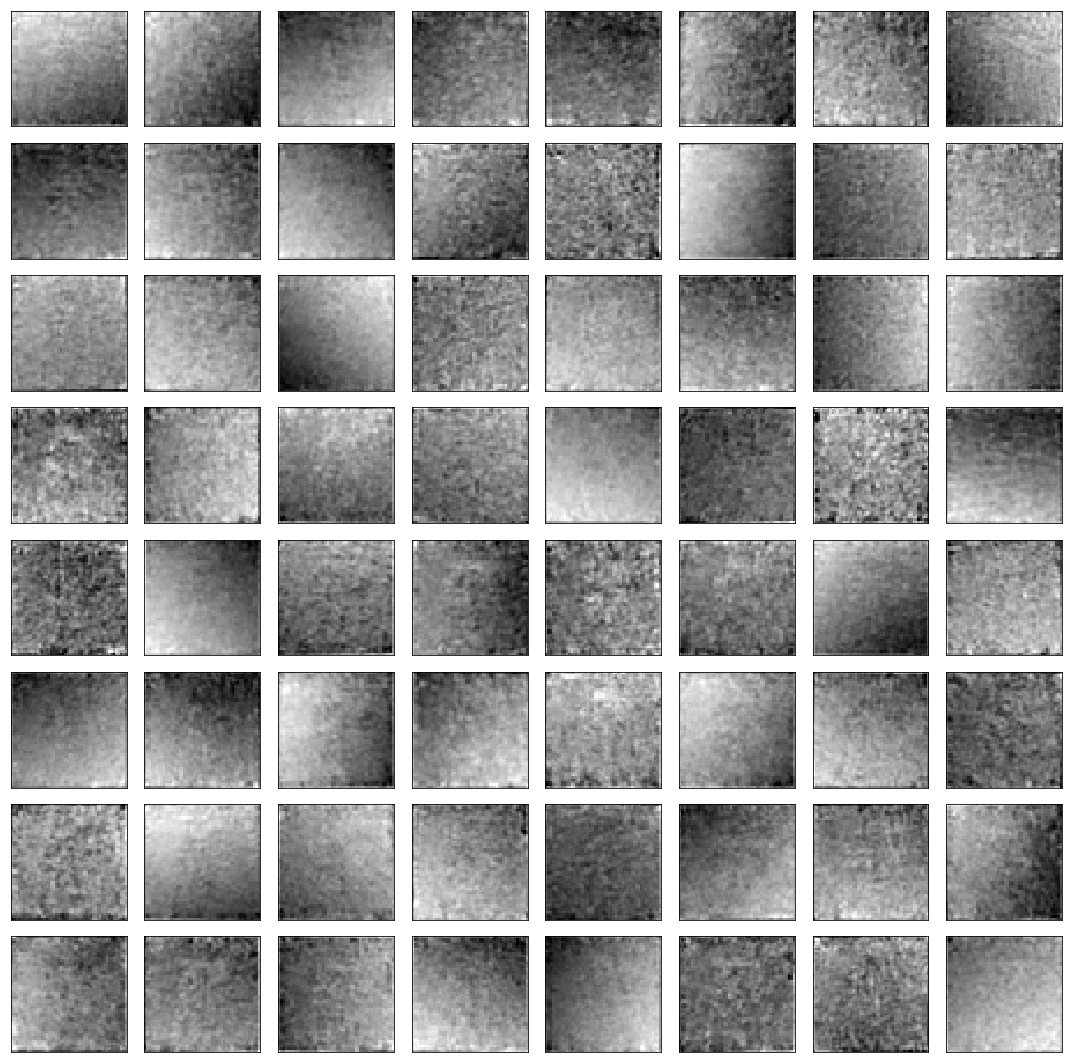

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


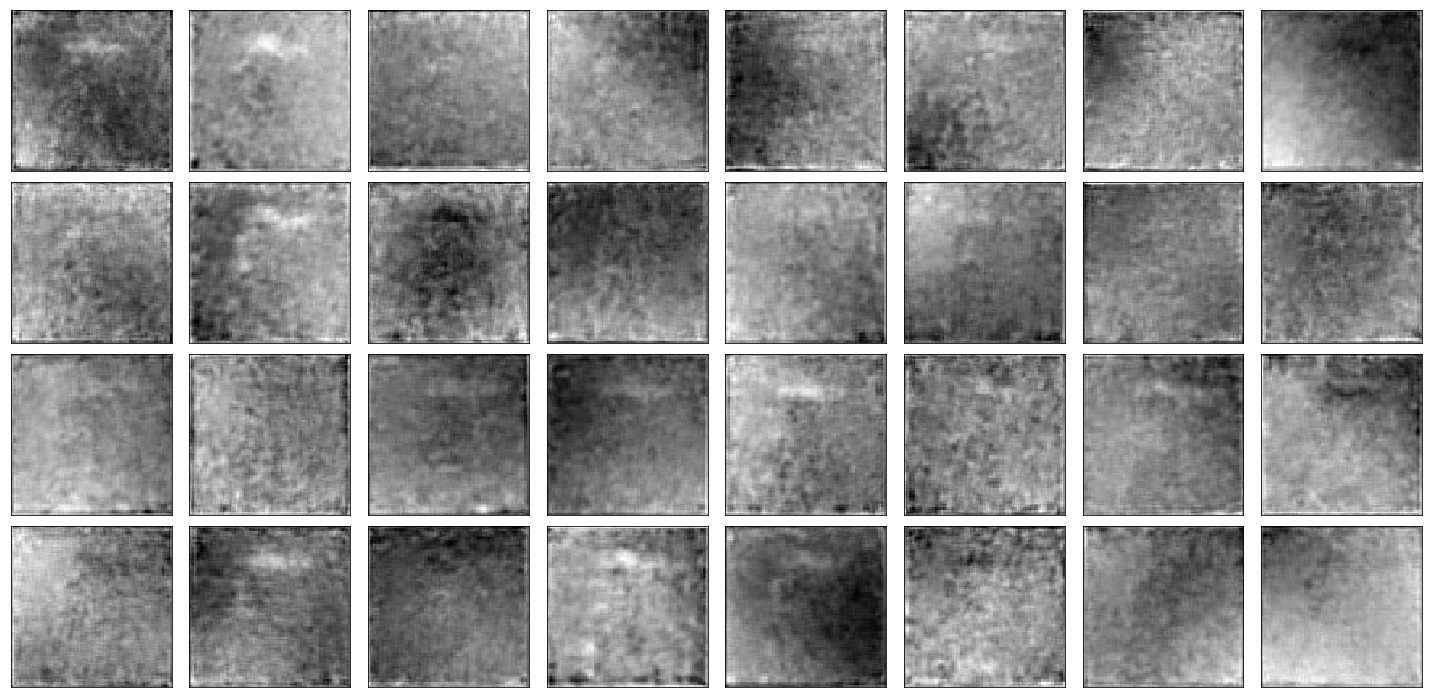

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

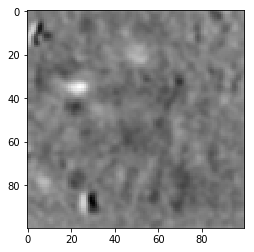

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


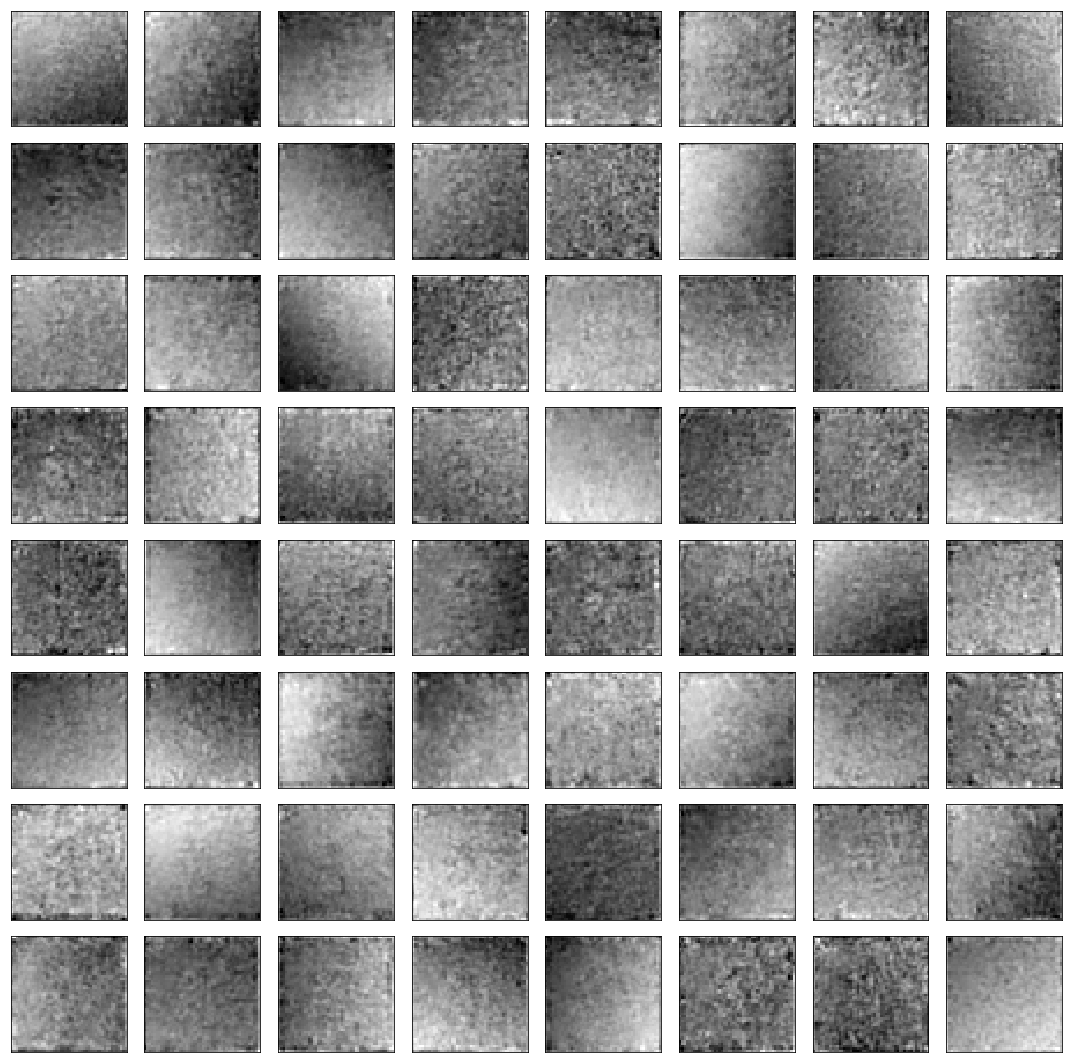

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


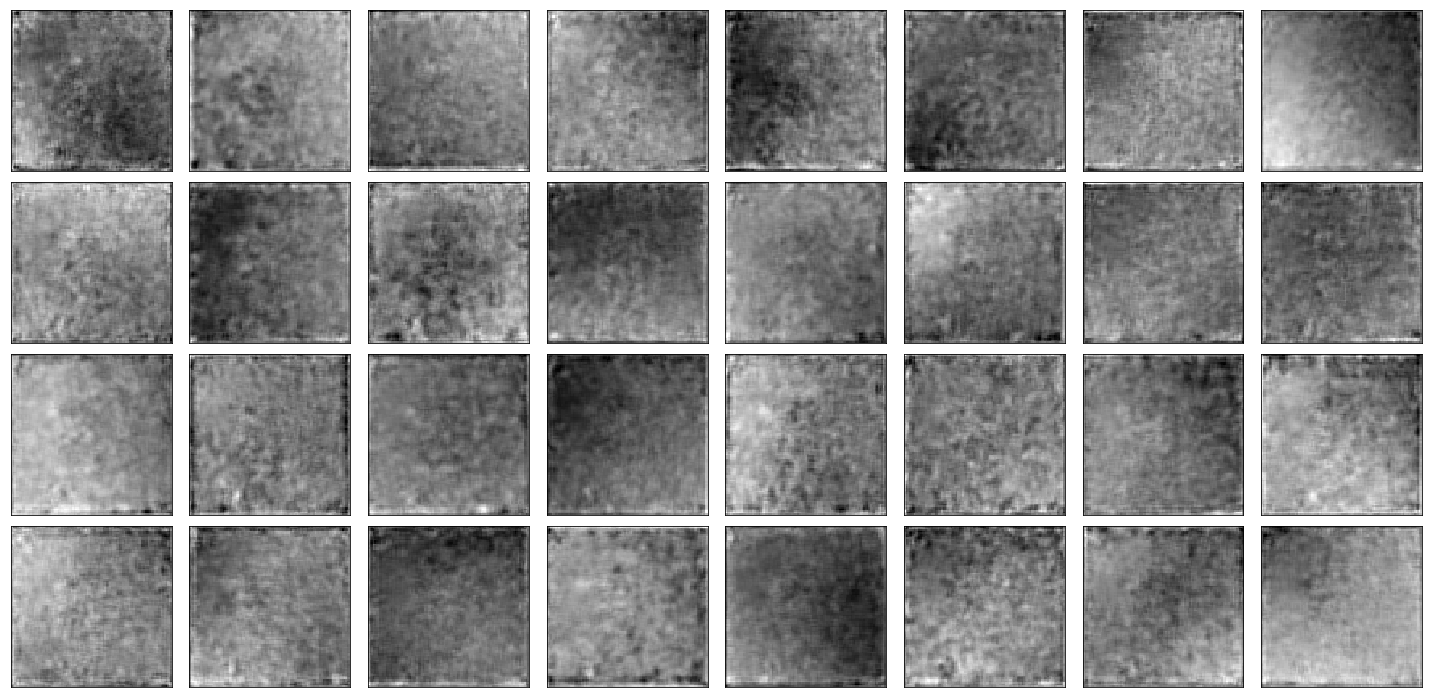

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

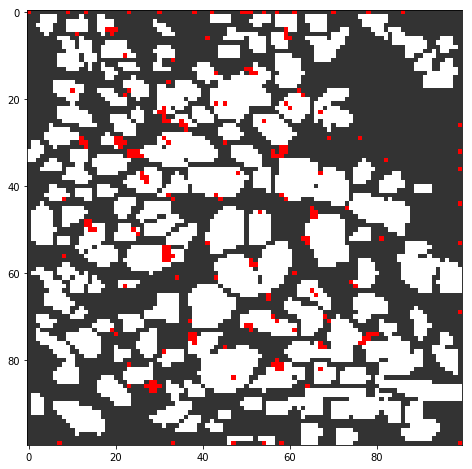

In [47]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

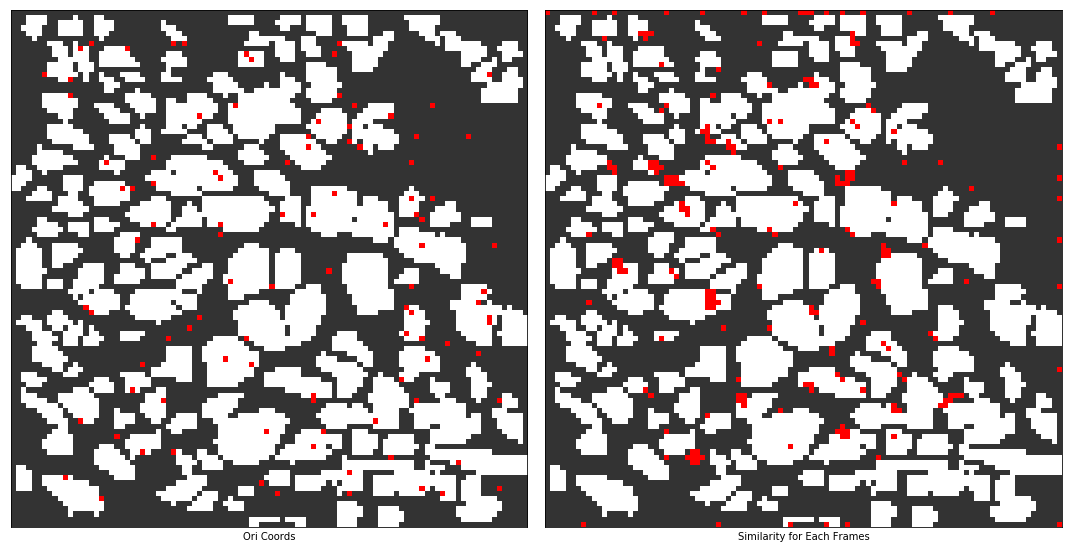

Counts:  201


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)